# IA Project - Face Recognition with Dynamic Triplet Loss

References: https://openaccess.thecvf.com/content_ICCV_2019/papers/Zhang_Learning_Local_Descriptors_With_a_CDF-Based_Dynamic_Soft_Margin_ICCV_2019_paper.pdf

Dataset: http://vis-www.cs.umass.edu/lfw/#download

In [1]:
import torch
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import numpy as np
import collections
import PIL.Image
from torch.utils.data import DataLoader, Subset
import os

In [2]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cpu


### Pre-precessing data

In [3]:
#path
data_path = "./LFW_DIR"
train_path = "./data/train_pairs.txt"
test_path = "./data/test_pairs.txt"
people_path = "./data/people.txt"

In [4]:
# loading dataset
# dataset = datasets.ImageFolder(data_path, transform = transform)
dataset = datasets.ImageFolder(data_path)
print(f"num samples: {len(dataset)}")

num samples: 13233


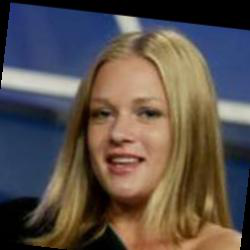

In [5]:
dataset[0][0]

In [6]:
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

test_transform = T.Compose([
    T.Resize(250),  # make 250x250
    T.CenterCrop(150),   # then take 150x150 center crop
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

train_transform = T.Compose([
    # per il training, la differenza risiede nel RandomCrop al posto del CenterCrop
    # e nell'aggiunta dell'RandomHorizontalFlip
    T.Resize(250),
    T.RandomCrop(150),
    T.RandomHorizontalFlip(p=0.5), # p è la probabilità che l'immagine venga ruotata
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

In [7]:
def read_pairsLFW(pairs_path):
    pairs = []
    with open(pairs_path, 'r') as file:
        for line in file.readlines()[1:]:
            pair = line.strip().split()
            pairs.append(pair)
    return pairs

In [8]:
# Liste delle coppie di immagini per training e testing
train_pairs = read_pairsLFW(train_path)
test_pairs = read_pairsLFW(test_path)

In [9]:
#funzione per estrarre le immagini delle coppie
def getImages(data_path, pairs):
    skipped_pairs = 0
    path_list = []
    is_same_list = []
    
    for pair in pairs:
        
        if len(pair) == 3: # allora sono della stessa persona
            path_first = os.path.join(data_path, pair[0], pair[0] + '_' + '%04d' % int(pair[1]) + '.jpg')
            path_second = os.path.join(data_path, pair[0], pair[0] + '_' + '%04d' % int(pair[2]) + '.jpg')
            is_same = True
            
        elif len(pair) == 4: # persone diverse
            path_first = os.path.join(data_path, pair[0], pair[0] + '_' + '%04d' % int(pair[1]) + '.jpg')
            path_first = os.path.join(data_path, pair[0], pair[0] + '_' + '%04d' % int(pair[3]) + '.jpg')
            is_same = False
            
        # verifico che entrambe le immagini esistano ai dati path
        if os.path.exists(path_first) and os.path.exists(path_second):
            path_list += (path_first, path_second)
            is_same_list.append(is_same)
        else:
            skipped_pairs += 1
    
    if skipped_pairs > 0:
        print(f"Pairs skipped: {skipped_pairs}")
    
    return path_list, is_same_list

In [10]:
train_path_list, is_same_train = getImages(data_path, train_pairs)
test_path_list, is_same_test = getImages(data_path, test_pairs)

Pairs skipped: 172
Pairs skipped: 68


In [11]:
# definiamo una sottoclasse di dataset per LFW
DEBUG = False

class LFWDataset(torch.utils.data.Dataset):

    def __init__(self, path_list, is_same_list, transforms, split = 'test'):
        
        self.files = collections.defaultdict(list)
        self.split = split
        self.files[split] =  path_list
        self.pair_label = is_same_list
        self.transforms = transforms

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_file = self.files[self.split][index]
        img = PIL.Image.open(img_file)
        if DEBUG:
            print(img_file)
        im_out = self.transforms(img)
        return im_out

In [12]:
# creiamo i dataset di training e testing
train_dataset = LFWDataset(train_path_list, is_same_train, transform)
test_dataset = LFWDataset(test_path_list, is_same_test, transform)

In [13]:
# Compute dataset sizes
num_train = len(train_dataset)
num_test = len(test_dataset)

print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

Num. training samples: 4056
Num. test samples:     1864


In [14]:
# List of indexes on the training set
train_idx = list(range(num_train))
# List of indexes on the test set
test_idx = list(range(num_test))

In [15]:
# Import
import random
# Shuffle training set
random.shuffle(train_idx)

In [16]:
# Validation fraction
val_frac = 0.1
# Compute number of samples
num_val = int(num_train*val_frac)
num_train = num_train - num_val
# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

In [17]:
# Split train_dataset into training and validation
val_dataset = Subset(train_dataset, val_idx)
train_dataset = Subset(train_dataset, train_idx)

In [18]:
# Define loaders
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, num_workers=4, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=64, num_workers=4, shuffle=False)

In [19]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

In [26]:
# PDF e CDF
# PDF è la Probability Distribution Function, che nel caso delle Triplet Loss è la funzione Normal Distribution
# CDF è la  Cumulative Distribution Function , utilizzata per la Dynamic Triplet Loss, è l'integrale della PDF
# Pytorch offre diverse distribuzioni. La CDF della Normal Distribution la troviamo così:
import torch.distributions.normal as distribution

"""
Parametri della normal_distribution:
    loc (float or Tensor) – (luogo del grafico dove si trova la) media della distribution (spesso chiamata mu)
    scale (float or Tensor) – deviazione standard della distribuzione (spesso chiamata sigma)
"""
loc = 0
scale = 1
normal_distribution = distribution.Normal(loc, scale)

def calcolo_cdf(value): # value è un tensore
    cdf = normal_distribution.cdf(value)

In [ ]:
# Model, CNN
# import: neural networks, functional, optimization
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Classe del Model
class CNN(nn.Module):
    
    # Constructor
    def __init__(self):
        # Call parent constructor
        super().__init__();
        # Create convolutional layers
        self.conv_layers = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 64, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            # Layer 2
            nn.Conv2d(64, 128, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            # Layer 3, con MaxPooling
            nn.Conv2d(128, 128, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 4, Normalization e MaxPooling
            nn.Conv2d(128, 256, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Create fully-connected layers
        self.fc_layers = nn.Sequential(
            # FC layer
            nn.Linear(4096, 1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            # Classification layer
            nn.Linear(1024, 10)
        )

    # Forward
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x